In [1]:
import numpy as np
import pims
import time

import matplotlib.pyplot as plt
from matplotlib import colors

from os import path

from scipy import ndimage
from scipy.io import savemat

from skimage import exposure
from skimage import filters
from skimage import transform
from skimage import restoration
from skimage import morphology

In [2]:
folder_path = path.join('D:','ultrasound_2_alex', '2020-12-11-SideFeed')

file_list = ['benchmark.cine']
video_list = [pims.open(path.join(folder_path,f_name)) for f_name in file_list]

In [3]:
# min_frame = np.Inf

# for video in video_list:
#     if(len(video) < min_frame):
#         min_frame = len(video)

# min_frame

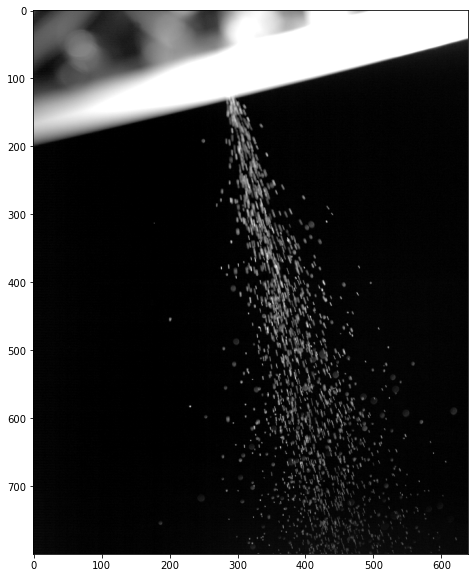

In [4]:
fig, axs = plt.subplots(figsize = (10,10))
axs.imshow(video_list[0][0], cmap = 'gray')
plt.show()

In [5]:
cropping = ((120,0),(0,0))

In [6]:
test_bench = pims.process.crop(video_list[0], cropping)

In [7]:
# @pims.pipeline
# def rotate(image, angle):
#     return transform.rotate(image, angle, resize=False, center=None)

# bench_rotate = rotate(video_list[0], -14)

# fig, axs = plt.subplots( figsize = (10,10))
# axs.imshow(bench_rotate[0], cmap = 'gray')
# plt.show()

In [8]:
# bench_crop = pims.process.crop(bench_rotate, cropping)

# fig, axs = plt.subplots( figsize = (10,10))
# axs.imshow(bench_crop[0], cmap = 'gray')
# plt.show()

In [9]:
# test_bench = rotate(bench_crop, 14)

# fig, axs = plt.subplots( figsize = (10,10))
# axs.imshow(test_bench[0], cmap = 'gray')
# plt.show()

In [10]:
@pims.pipeline
def denoise_nl(image):
    sig = restoration.estimate_sigma(image,average_sigmas = True)
    return restoration.denoise_nl_means(image, sigma = sig)

@pims.pipeline
def denoise_median(image):
    selem = morphology.disk(3)
    return filters.median(image, selem)

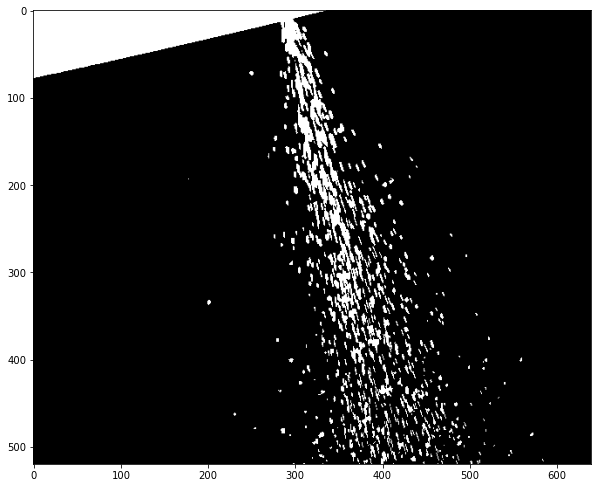

In [11]:
@pims.pipeline
def binarise(image):
    thresh = filters.threshold_otsu(image)
    return (thresh <= image).astype(int)

@pims.pipeline
def binarise_half_way(image):
    min_val = np.min(image)
    max_val = np.max(image)
    return ((min_val+(max_val-min_val)*0.25) <= image).astype(int)

binary_vid_bench = binarise_half_way(test_bench)

fig, axs = plt.subplots(figsize = (10,10))
axs.imshow(binary_vid_bench[0],cmap = 'gray')
plt.show()

In [12]:
max_range = 4000
skip = 5
sampled_frame = np.arange(0, max_range, skip)

In [13]:
start = time.process_time() 
h_t_bench = np.sum(binary_vid_bench[sampled_frame], axis = 0)
end = time.process_time() 

print('processing time: {}'.format(end-start))

processing time: 32.984375


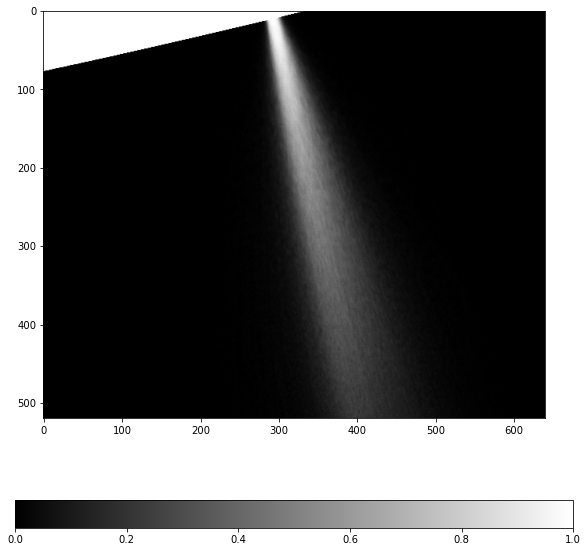

In [14]:
norm = colors.Normalize(vmin=0, vmax=1)

normed_h_t_bench = h_t_bench/np.max(h_t_bench)

fig, axs = plt.subplots(figsize = (10,10))
bench_im = axs.imshow(normed_h_t_bench, cmap = 'gray')

bench_im.set_norm(norm)

fig.colorbar(bench_im, ax=axs, orientation='horizontal', fraction=.1)
plt.show()

In [15]:
bench_mark_data = np.zeros((len(video_list),h_t_bench.shape[0],h_t_bench.shape[1]))

for i, vid in enumerate(video_list):
    cropped_vid = pims.process.crop(vid, cropping)
    binary_vid = binarise_half_way(cropped_vid)
    bench_mark_data[i] = np.sum(binary_vid[sampled_frame], axis = 0)

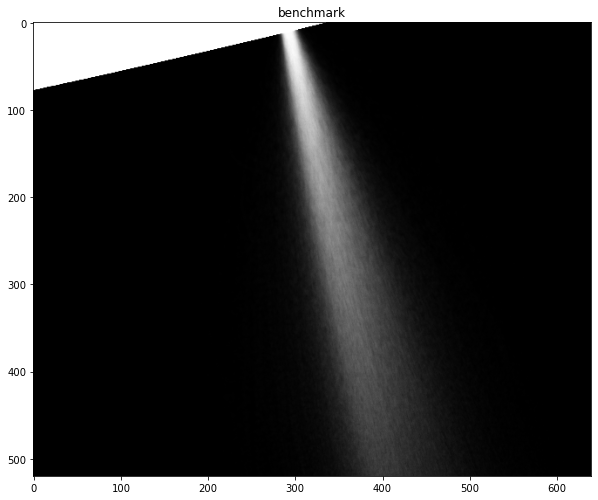

In [16]:
fig, axs = plt.subplots( figsize = (10,10))

axs.set_title('benchmark')
axs.imshow(bench_mark_data[0], cmap = 'gray')

plt.show()

In [17]:
output_path = 'benchmark.mat'
savemat(output_path, {'im_benchmark': bench_mark_data[0]})